In [50]:
! . .venv/bin/activate
! sstat -j $SLURM_JOB_ID 

JobID         MaxVMSize  MaxVMSizeNode  MaxVMSizeTask  AveVMSize     MaxRSS MaxRSSNode MaxRSSTask     AveRSS MaxPages MaxPagesNode   MaxPagesTask   AvePages     MinCPU MinCPUNode MinCPUTask     AveCPU   NTasks AveCPUFreq ReqCPUFreqMin ReqCPUFreqMax ReqCPUFreqGov ConsumedEnergy  MaxDiskRead MaxDiskReadNode MaxDiskReadTask  AveDiskRead MaxDiskWrite MaxDiskWriteNode MaxDiskWriteTask AveDiskWrite TRESUsageInAve TRESUsageInMax TRESUsageInMaxNode TRESUsageInMaxTask TRESUsageInMin TRESUsageInMinNode TRESUsageInMinTask TRESUsageInTot TRESUsageOutAve TRESUsageOutMax TRESUsageOutMaxNode TRESUsageOutMaxTask TRESUsageOutMin TRESUsageOutMinNode TRESUsageOutMinTask TRESUsageOutTot 
------------ ---------- -------------- -------------- ---------- ---------- ---------- ---------- ---------- -------- ------------ -------------- ---------- ---------- ---------- ---------- ---------- -------- ---------- ------------- ------------- ------------- -------------- ------------ --------------- --------------- 

In [51]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [52]:
project_dir = "../../../"
games = pd.read_csv(f'{project_dir}/games.csv')
plays = pd.read_csv(f'{project_dir}/plays.csv')
players = pd.read_csv(f'{project_dir}/players.csv')
tracking_df = pd.read_csv(f'{project_dir}/tracking_week_2.csv')
player_play = pd.read_csv(f'{project_dir}/player_play.csv')

# Change Version

In [82]:
version = "v2"

# Get Plays With Pressure

In [54]:
# Filter for plays where any defensive player caused pressure
# Select only rows where 'causedPressure' is True, and keep unique gameId-playId pairs
plays_with_pressure = player_play[player_play['causedPressure'] == True][['gameId', 'playId']].drop_duplicates()

# Merge plays with plays_with_pressure to create a labeled dataset
# Add a new column 'causedPressure' to indicate if pressure was caused on a play
# Use a left merge and set '_merge' column to check if the play exists in plays_with_pressure
plays['causedPressure'] = plays.merge(plays_with_pressure, on=['gameId', 'playId'], how='left', indicator=True)['_merge'] == 'both'
plays['causedPressure'] = plays['causedPressure'].astype(int)  # Convert boolean values to 0/1 


# Get rushing plays and filter them out

In [55]:
plays_with_rushing = player_play[player_play['hadRushAttempt'] == True][['gameId', 'playId']].drop_duplicates()

# Remove all plays where there was a rushing attempt
plays = plays[~plays.set_index(['gameId', 'playId']).index.isin(plays_with_rushing.set_index(['gameId', 'playId']).index)]

#Print how many plays were removed
print(f"Number of plays removed: {len(plays_with_rushing)}")


Number of plays removed: 6788


# Plot and remove plays where the QB held the ball for too long

[2.99  1.836 2.236 ... 2.242 1.766 1.937]
['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']


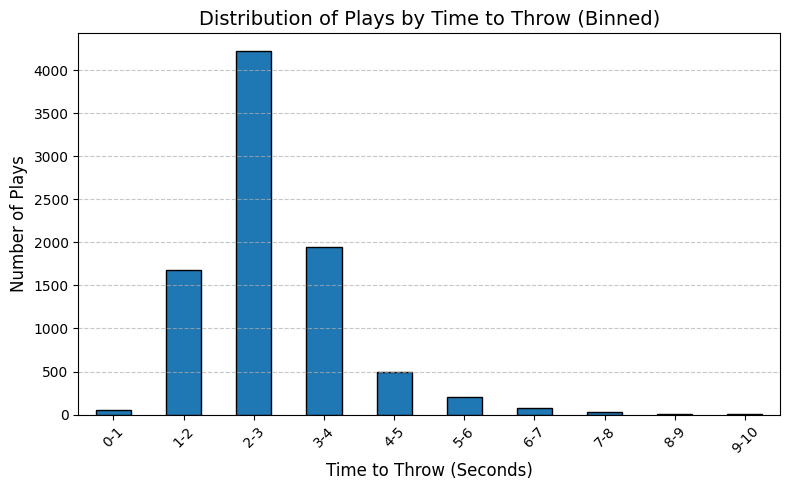

There are 814 plays where the QB holds the ball for more than 4 seconds


In [56]:
# Print out the unique values for teh timeToThrow column
print(plays["timeToThrow"].unique())

# Define bins for each second
bins = range(0, int(plays["timeToThrow"].max()) + 2)  # Adding 2 to include the upper boundary
labels = [f"{i}-{i+1}" for i in bins[:-1]]  # Labels for each bin
print(labels)

# Bin the data
plays["timeToThrow_binned"] = pd.cut(plays["timeToThrow"], bins=bins, labels=labels, right=False)

# Count the distribution
distribution = plays["timeToThrow_binned"].value_counts(sort=False)

# Plot the distribution
plt.figure(figsize=(8, 5))
distribution.plot(kind="bar", edgecolor="black")
plt.title("Distribution of Plays by Time to Throw (Binned)", fontsize=14)
plt.xlabel("Time to Throw (Seconds)", fontsize=12)
plt.ylabel("Number of Plays", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Filter the distribution for bins "4-5" and larger
filtered_bins = distribution[distribution.index >= "4-5"]

# Print the total count of plays in these bins
count_in_filtered_bins = filtered_bins.sum()
print(f"There are {count_in_filtered_bins} plays where the QB holds the ball for more than 4 seconds")

In [57]:
# Remove all plays where the QB holds the ball for more than 4 seconds
print(filtered_bins.index)
plays = plays[~plays["timeToThrow_binned"].isin(filtered_bins.index)]

CategoricalIndex(['4-5', '5-6', '6-7', '7-8', '8-9', '9-10'], categories=['0-1', '1-2', '2-3', '3-4', ..., '6-7', '7-8', '8-9', '9-10'], ordered=True, dtype='category', name='timeToThrow_binned')


# Optional: Save the filtered DF

In [58]:
plays.to_csv("CSVs/plays_filtered.csv", index=False)

# Add Offensive Formation

There are 23 missing values in the 'offenseFormation' column


/scratch/local/54503680/ipykernel_1168319/3891130981.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=formation_counts.index, y=formation_counts.values, palette='viridis')


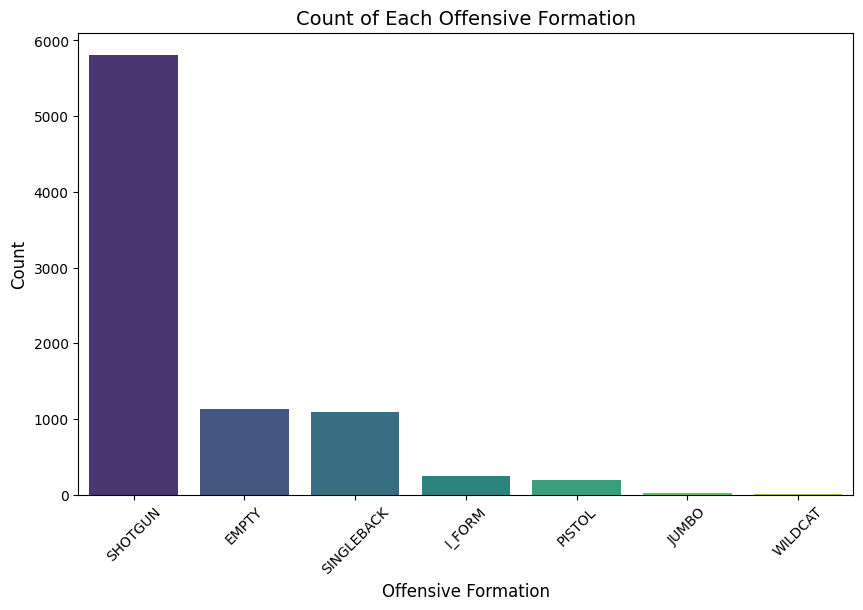

In [59]:
# One hot encode the offensive formation
one_hot_encoded_offense_formations = pd.get_dummies(plays['offenseFormation'], prefix='formation')
plays = pd.concat([plays, one_hot_encoded_offense_formations], axis=1) 

# Print the new offensive formations
offense_cols = one_hot_encoded_offense_formations.columns

#Print how many are nan 
print(f"There are {plays['offenseFormation'].isnull().sum()} missing values in the 'offenseFormation' column")

# Plot the count of each offensive formation
formation_counts = plays['offenseFormation'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=formation_counts.index, y=formation_counts.values, palette='viridis')
plt.title('Count of Each Offensive Formation', fontsize=14)
plt.xlabel('Offensive Formation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()



# Add Defensive Formation

/scratch/local/54503680/ipykernel_1168319/2142759953.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=formation_counts.index, y=formation_counts.values, palette='viridis')


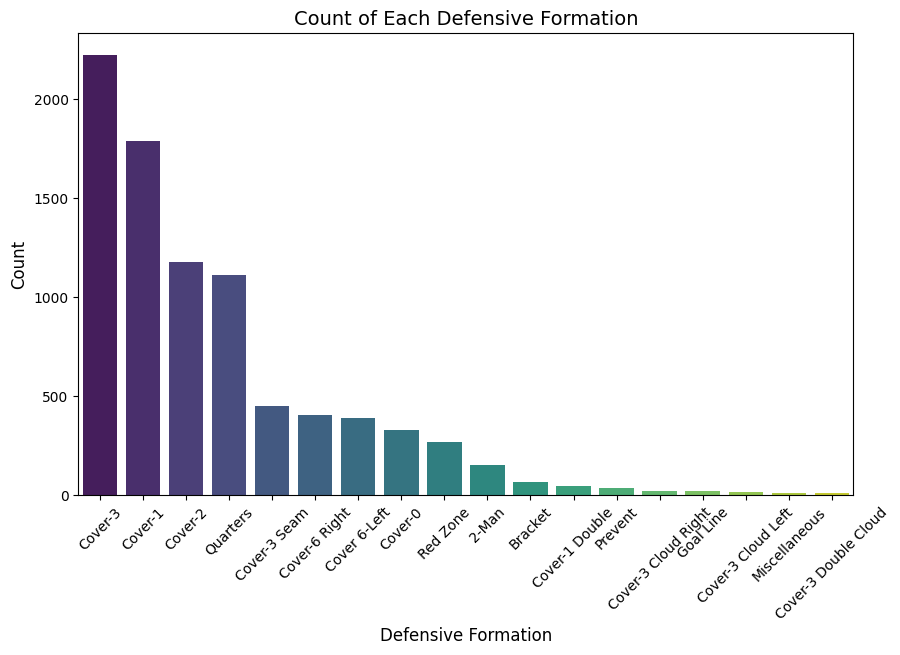

In [60]:
# One hot encode the defensive formation
one_hot_encoded_defense_formations = pd.get_dummies(plays['pff_passCoverage'], prefix='formation')
plays = pd.concat([plays, one_hot_encoded_defense_formations], axis=1)

# Get the new defensive formations columns
defense_cols = one_hot_encoded_defense_formations.columns

# Plot the count of each offensive formation
formation_counts = plays['pff_passCoverage'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=formation_counts.index, y=formation_counts.values, palette='viridis')
plt.title('Count of Each Defensive Formation', fontsize=14)
plt.xlabel('Defensive Formation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


# Add " Player in Motion at Snap":

In [61]:
in_motion = player_play[player_play['inMotionAtBallSnap'] == True][['gameId', 'playId']].drop_duplicates()

# For every play in the play df, if a row has the same gameId and playId as a row in in_motion, set the 'inMotionAtBallSnap' column to True
plays['inMotionAtBallSnap'] = plays.set_index(['gameId', 'playId']).index.isin(in_motion.set_index(['gameId', 'playId']).index)

# Add "Number of each player position":

In [62]:
# Step 1: Join player_play with player to add the 'position' column
player_play = player_play.merge(players[['nflId', 'position']], on='nflId', how='left')

# Step 2: Group by gameId and playId, then count the number of unique positions for each play
position_counts = (
    player_play.groupby(['gameId', 'playId', 'position'])
    .size()  # Count occurrences
    .reset_index(name='count')  # Rename the count column
)

# Print all unique positions in position_counts "position" column
print(position_counts['position'].unique())
positions_names = position_counts['position'].unique()

# Step 3: Pivot the position counts so each position becomes a column
position_pivot = position_counts.pivot(index=['gameId', 'playId'], columns='position', values='count').fillna(0)

# Step 4: Convert counts to integers to avoid float issues after filling NaN
position_pivot = position_pivot.astype(int)

# Step 5: Merge the cleaned position_pivot into the plays DataFrame
plays = plays.merge(position_pivot, on=['gameId', 'playId'], how='left')

# Print the resulting plays DataFrame
print(plays.head())


['C' 'CB' 'DE' 'DT' 'FS' 'G' 'ILB' 'NT' 'QB' 'RB' 'SS' 'T' 'TE' 'WR' 'FB'
 'OLB' 'MLB' 'DB' 'LB']
       gameId  playId                                    playDescription  \
0  2022102302    2655  (1:54) (Shotgun) J.Burrow pass short middle to...   
1  2022091809    3698  (2:13) (Shotgun) J.Burrow pass short right to ...   
2  2022103004    3146  (2:00) (Shotgun) D.Mills pass short right to D...   
3  2022110610     348  (9:28) (Shotgun) P.Mahomes pass short left to ...   
4  2022091104    3662  (12:51) (Shotgun) J.Hurts pass incomplete shor...   

   quarter  down  yardsToGo possessionTeam defensiveTeam yardlineSide  \
0        3     1         10            CIN           ATL          CIN   
1        4     1         10            CIN           DAL          CIN   
2        4     3         12            HOU           TEN          HOU   
3        1     2         10             KC           TEN          TEN   
4        4     3         12            PHI           DET          PHI   

   yar

# Additional Features: 

In [63]:
additional_features =  ['quarter'] + ['down'] + ['yardsToGo'] + ['inMotionAtBallSnap']

# Get final dataset

In [83]:
# Select the relevant columns
selected_columns = ['causedPressure'] + list(defense_cols) + list(positions_names) + additional_features + ["formation_SHOTGUN"] #+ list(offense_cols) 
final_df = plays[selected_columns]

# Display the new dataframe
print(final_df.columns)

Index(['causedPressure', 'formation_2-Man', 'formation_Bracket',
       'formation_Cover 6-Left', 'formation_Cover-0', 'formation_Cover-1',
       'formation_Cover-1 Double', 'formation_Cover-2', 'formation_Cover-3',
       'formation_Cover-3 Cloud Left', 'formation_Cover-3 Cloud Right',
       'formation_Cover-3 Double Cloud', 'formation_Cover-3 Seam',
       'formation_Cover-6 Right', 'formation_Goal Line',
       'formation_Miscellaneous', 'formation_Prevent', 'formation_Quarters',
       'formation_Red Zone', 'C', 'CB', 'DE', 'DT', 'FS', 'G', 'ILB', 'NT',
       'QB', 'RB', 'SS', 'T', 'TE', 'WR', 'FB', 'OLB', 'MLB', 'DB', 'LB',
       'quarter', 'down', 'yardsToGo', 'inMotionAtBallSnap',
       'formation_SHOTGUN'],
      dtype='object')


# Create the train, test, val split

### Undersample for the train, use realistic proportions for the val and test
### 70 - 15 - 15 split of the causedPressure = 1 data

In [84]:
# Get the indices of rows where causedPressure is 1
pressure_1_indices = final_df[final_df['causedPressure'] == 1].index
print(f"Number of rows where causedPressure is 1: {len(pressure_1_indices)}")

# Get the indices of rows where causedPressure is 0
pressure_0_indices = final_df[final_df['causedPressure'] == 0].index
print(f"Number of rows where causedPressure is 0: {len(pressure_0_indices)}")

# Shuffle them both
np.random.permutation(pressure_1_indices)
np.random.permutation(pressure_0_indices)

# Creaet a df that uses 70% of pressure_1_indices and matches that number with pressure_0_indices
train_indices = pressure_1_indices[:int(0.7*len(pressure_1_indices))].tolist() + pressure_0_indices[:int(0.7*len(pressure_1_indices))].tolist()
np.random.permutation(train_indices)
train_df = final_df.loc[train_indices]

Number of rows where causedPressure is 1: 2582
Number of rows where causedPressure is 0: 5940


### Test and Val

In [85]:
# For the test and val, we want to keep the orginial percentage of pressure_1_indices 
percentage_of_pressure_1_indices = len(pressure_1_indices)/(len(pressure_0_indices) + len(pressure_1_indices))
print(f"Percentage of pressure_1_indices plays: {percentage_of_pressure_1_indices}")

remaining_pressure_1_indices = pressure_1_indices[int(0.7*len(pressure_1_indices)):]  # Remaining 30% of pressure_1_indices
test_pressure1_indices = remaining_pressure_1_indices[:int(.50*len(remaining_pressure_1_indices))] # 15% of pressure_1_indices
val_pressure1_indices = remaining_pressure_1_indices[int(0.50*len(remaining_pressure_1_indices)):] # 15% of pressure_1_indices

# Calculate the total number of rows needed for test and validation to maintain the original percentage
remaining_pressure_1_count = len(remaining_pressure_1_indices)
test_pressure1_count = len(test_pressure1_indices)
val_pressure1_count = len(val_pressure1_indices)

# Calculate the corresponding number of pressure_0_indices for test and validation
test_pressure0_count = int((1 - percentage_of_pressure_1_indices) / percentage_of_pressure_1_indices * test_pressure1_count)
val_pressure0_count = int((1 - percentage_of_pressure_1_indices) / percentage_of_pressure_1_indices * val_pressure1_count)

# Select the required number of pressure_0_indices for test and validation
remaining_pressure_0_indices = pressure_0_indices[int(0.7 * len(pressure_1_indices)):]
test_pressure0_indices = remaining_pressure_0_indices[:test_pressure0_count]
val_pressure0_indices = remaining_pressure_0_indices[test_pressure0_count:test_pressure0_count + val_pressure0_count]

# Combine the indices for test and validation sets
test_indices = test_pressure1_indices.tolist() + test_pressure0_indices.tolist()
val_indices = val_pressure1_indices.tolist() + val_pressure0_indices.tolist()

# Shuffle the test and validation indices
test_indices = np.random.permutation(test_indices)
val_indices = np.random.permutation(val_indices)

# Create test and validation DataFrames
test_df = final_df.loc[test_indices]
val_df = final_df.loc[val_indices]

# Final output
print(f"Number of rows in train_df: {len(train_df)} with pressure percenrage of {train_df['causedPressure'].mean()}")
print(f"Number of rows in test_df: {len(test_df)} with pressure percenrage of {test_df['causedPressure'].mean()}")
print(f"Number of rows in val_df: {len(val_df)} with pressure percenrage of {val_df['causedPressure'].mean()}")

Percentage of pressure_1_indices plays: 0.30298052100445905
Number of rows in train_df: 3614 with pressure percenrage of 0.5
Number of rows in test_df: 1277 with pressure percenrage of 0.303054032889585
Number of rows in val_df: 1280 with pressure percenrage of 0.303125


In [86]:
# Save the dataframes to model_data folder
train_df.to_csv(f'model_data/{version}/train.csv', index=False)
test_df.to_csv(f'model_data/{version}/test.csv', index=False)
val_df.to_csv(f'model_data/{version}/val.csv', index=False)